# TODO:
- change the name of the *test* method
- check what *pz* is
- provare diverso dataset

# Restricted Boltzmann Machine - MNIST

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from sklearn.datasets import fetch_openml
from IPython.display import HTML

In [2]:
class LOGlike(object):
    """
    FORMAT:
    D = 784      # visible
    L = 12       # hidden
    M = len(x)   # number of data points
    a = np.random.uniform(-1, 1, D)
    b = np.random.uniform(-1, 1, L)
    x = np.random.randint(0, 2, (M, D))
    z = np.random.randint(0, 2, L)
    w = np.random.uniform(-1, 1, (D, L))
    """

    def __init__(self, x, L, spins = False):
        self.a = None # a   # visible
        self.b = None # b   # hidden
        self.D = None # a.shape[0]
        self.L = None # b.shape[0]
        self.x = x
        self.spins = spins
        self.M = len(x)
        self.w = None # w
        self.q = None
        self.k = None
        self.esit = []
        self.esit_ix = []
        self.z = None
        #
    #####
    #
    def initialization(self, a, b, w):
        self.a = a   # visible
        self.b = b   # hidden
        self.D = a.shape[0]
        self.L = b.shape[0]
        self.w = w
        self.make_z_states()
        self.H_and_G()
        #
    #####
    #
    def H_and_G(self):
        
        self.H_z_matrix = np.array([self.H(z) for z in self.z])  # Shape (2^L, D)
        self.G_z_vector = np.array([self.G(z) for z in self.z])  # Shape (2^L,)
        tmp             = self.H_z_matrix @ self.x.T
        self.k          = np.mean(tmp)
        #
    #####
    #
    def make_z_states(self):
        """
        2^L config
        """
        
        def get_bin(i, L):
            b = bin(i)[2:]
            return ("0" * (L - len(b))) + b
            #
        #####
        #
        self.z = np.array([[int(bit) for bit in get_bin(i, self.L)]
                                       for i in range(2 ** self.L)])
        if self.spins:
            self.z[self.z == 0] = -1
            #
        #####
        #
    #####
    #
    def H(self, z):
        """
        H(z) = a + w @ z
        """
        
        return self.a + np.dot(self.w, z)
        #
    #####
    #
    def G(self, z):
        """
        G(z) = exp(b @ z).
        """
        
        return np.exp(np.dot(self.b, z))
        #
    #####
    #
    def get_logsumexp(self, exps):
        max   = exps.max()
        exps  = exps[exps >= (max - 50)]
        min   = exps.min()
        exps -= min
        esit  = min + np.log(np.exp(exps).sum())
        return esit
        #
    #####
    #
    def get_numerator(self, x):
        """
        ln{sum_z[G(z) * exp[dot(H_i(z) * x_i)]]}
        """

        # return scipy.special.logsumexp(self.H_z_matrix @ x)
        exps      = np.log(self.G_z_vector) + (self.H_z_matrix @ x)  # Shape (2^L,)
        return self.get_logsumexp(exps)
        # numerator = np.sum(self.G_z_vector * exp_H_x)
        # return k + np.log(numerator)
        #
    #####
    #
    def get_denominator(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[(1 + H_i(z)) / q]]}
        """

        # q average over 1+exp(H_i(z))
        self.q = 1 + np.exp(np.mean(self.H_z_matrix))

        # sum_Z
        prod_H_q = np.prod((1 + np.exp(self.H_z_matrix)) / self.q, axis = 1)  # Shape (2^L,)
        Z_value  = np.sum(self.G_z_vector * prod_H_q)

        return self.D * np.log(self.q) + np.log(Z_value)
        #
    #####
    #
    def get_denominator_spin(self):
        """
        ln(Z) = D * ln(q) + ln{sum_z[G(z) * prod_i[cosh(H_i(z)) / q]]}
        """
        
        #return scipy.special.logsumexp()
        # q average over cosh(H_i(z))
        #self.q = np.cosh(np.mean(self.H_z_matrix))
        #
        # sum_Z
        #prod_H_q = np.prod(2 * np.cosh(self.H_z_matrix) / self.q, axis = 1)  # Shape (2^L,)
        #Z_value  = np.sum(self.G_z_vector * prod_H_q)
        #
        #return self.D * np.log(self.q) + np.log(Z_value)    
        #
        approx = 100
        max    = self.H_z_matrix.max()
        shift  = max + approx
        exps   = np.log(self.G_z_vector) + (abs(self.H_z_matrix - shift)).sum(axis = 1)
        esit   = self.get_logsumexp(exps)
        return self.D * shift + esit
        #
    #####
    #
    def run(self):
        """
        l_θ(x) = ln{sum_z[G(z) * exp(H_i(z) * x_i)]} - ln{Z}
        """
        if (self.spins == False):
            lnZ = self.get_denominator()
        else:
            lnZ = self.get_denominator_spin()
            #
        #####
        #
        log_likelihoods = np.array([self.get_numerator(x) - lnZ for x in self.x])
        self.esit.append(np.mean(log_likelihoods))
        #
    #####
    #
    def save(self):
        print(self.esit)
        '''file = open("L/" + str(self.L) + ".txt", "tw")
        file.write(str(self.esit))
        file.close()'''
        #
    #####
    #
#####

In [5]:
class RBM:
    def __init__(self, x, L, spins=False, potts=False):
        """
        - x: dataset
        - L: number of hidden units
        - spins: if True sets x_min=-1, else x_min=0
        """
        
        if potts and spins: raise ValueError("Potts and Spins cannot coexist.")
        
        self.x_min = -1 if spins else 0
        self.x_max = 1
        self.x = binarize_data(x, self.x_min, self.x_max)
        self.data_size = len(self.x)
        self.potts = potts
        
        self.D = self.x.shape[1]
        self.L = L
        
        self.params = {
            "w": None,
            "a": None, 
            "b": None
        }
        self.params_history = {
            "w": [], 
            "a": [], 
            "b": []
        }
        
        self.log_likelihood = LOGlike(self.x, self.L, spins=spins)

    def hinton_bias_init(self):
        xmean = np.mean(self.x, axis=0)

        # avoid divergence in log
        delta = 1e-4
        xmean = np.clip(xmean, self.x_min + delta, self.x_max - delta)

        return np.clip(np.log(xmean-self.x_min) - np.log(self.x_max-xmean), -300, 300) 
    
    def initialize_params(self):
        self.params = {
            "w": np.sqrt(4/(self.L + self.D)) * np.random.randn(self.D, self.L),
            "a": self.hinton_bias_init(),
            "b": np.zeros(self.L)
        }
        
        self.params_history = {param: [self.params[param].copy()] for param in self.params.keys()}
    
    def contrastive_divergence(self, vector_input, weights, biases, POTTS=False):
        H = np.clip( np.dot(vector_input, weights) + biases, -300, 300 )
        a = np.exp( (self.x_max - self.x_min) * H )

        output_size = H.shape
        vector_output = np.full(output_size, self.x_min)
        
        if POTTS:
            p = a / np.sum(a) # state probability
            F = np.cumsum(p) # cumulative probability
            r = np.random.rand()
            i = 0
            while r > F[i]:
                i += 1
            vector_output[i] = 1
            
        else:
            p = a / (a + 1) # local probability
            vector_output[np.random.random(output_size) < p] = self.x_max
        
        return vector_output

    def plot_weights_bias(self, weights, biases, cols=0, s=1.5, cmap="bwr", vmin=-4, vmax=4):
        """TODO: upgrade"""
        rows = int(np.ceil( self.L / cols))
        plt.clf()
        fig, axes = plt.subplots(rows, cols, figsize=(s*(1+cols), s*rows))
        for i in range(rows):
            for j in range(cols):
                if cols == 1:
                    ax = axes[i]
                else:
                    ax = axes[i,j]
                if i == j == 0:
                    ax.imshow(biases.reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title("bias")
                else:
                    ax.imshow(weights.T[i*cols+j-1].reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                    ax.set_title(f"hidden {i*cols+j}")
                ax.set_xticks([])
                ax.set_yticks([])

        plt.subplots_adjust(hspace=.3)
        plt.show()
        plt.close()

    def training(self, optimizer="RMSprop", epochs=150, batches=20, batch_i=10, batch_f=500, 
                 lr=0.05, epsilon=1e-4, cd_steps=2, gamma=0.001, verbose=False):
        
        if optimizer == "SGD":
            lr_i, lr_f = 1., 0.25
        elif optimizer == "RMSprop":
            lr_i = lr_f = lr
            beta, epsilon = 0.9, epsilon
        else:
            raise ValueError("Optimizer should either be SGD or RMSprop.")
        
        s = {param:np.zeros_like(self.params[param]) for param in ["w", "a", "b"]}
        list_indices = np.arange(self.x.shape[0])
        
        for epoch in range(1, epochs+1):
            q = (epoch - 1) / (epochs - 1)
            batch_size = int(batch_i + (batch_f-batch_i) * q**2)
            lr = lr_i + (lr_f-lr_i) * q
            
            for _ in range(batches):
                v_data, v_model = [np.zeros(self.D) for _ in range(2)]
                h_data, h_model = [np.zeros(self.L) for _ in range(2)]
                vh_data, vh_model = [np.zeros((self.D,self.L)) for _ in range(2)]
                
                selected_indices = np.random.choice(list_indices, batch_size, replace=False)
                for i in range(batch_size):
                    # positive CD phase
                    v = self.x[selected_indices[i]]
                    h = self.contrastive_divergence(v, self.params["w"], self.params["b"], POTTS=self.potts)
                    
                    v_data += v
                    h_data += h
                    vh_data += np.outer(v, h)
                    
                    # generate fantasy data
                    hf = h.copy()
                    for _ in range(cd_steps):
                        # negative CD phase
                        vf = self.contrastive_divergence(hf, self.params["w"].T, self.params["a"])
                        # positive CD phase
                        hf = self.contrastive_divergence(vf, self.params["w"], self.params["b"], POTTS=self.potts)

                    v_model += vf
                    h_model += hf
                    vh_model += np.outer(vf, hf)
                    
                # gradient of likelihood
                data_models = {
                    "w": (vh_data,vh_model),
                    "a": (v_data,v_model),
                    "b": (h_data,h_model)
                }
                for param,(d,m) in data_models.items():            
                    grad_theta = (d - m) / batch_size
                    
                    if optimizer == "RMSprop":
                        s[param] = beta * s[param] + (1-beta) * grad_theta**2
                        new_param = lr * grad_theta / np.sqrt(epsilon + s[param])
                    else:
                        new_param = lr * grad_theta

                    self.params[param] += new_param

                    if gamma > 0:
                        self.params[param] -= (gamma * lr) * np.sign(self.params[param])
            
            # save weights and biases for every epoch
            for param in ["w", "a", "b"]:
                self.params_history[param].append(self.params[param].copy())
            
            # plot training process
            if verbose:
                print(f"Epoch: {epoch} / {epochs}", end="\r")
                
                # if epoch % 20 == 0: self.plot_weights_bias(self.params["w"], self.params["a"], cols=self.L//2)
        
        print("Training complete.")
    
    def test(self, v_test, n=200, af=1):
        v = v_test.copy()
        v_history = []
        h_history = []
        for _ in range(n):
            h = self.contrastive_divergence(v, self.params["w"], self.params["b"], POTTS=self.potts)
            v = self.contrastive_divergence(h, af*self.params["w"].T, af*self.params["a"])
            v_history.append(v)
            h_history.append(h)
        
        return v_history, h_history

    '''def likelihood_history(self, n=5):
        self.log_likelihood.esit = []
        if n == 1:
            list_ix = [-1]
        else:
            list_ix = np.linspace(0, len(self.params_history["w"])-1, n, dtype=int)
        self.log_likelihood.esit_ix = list_ix.copy()
        
        for ix in list_ix:
            self.log_likelihood.inizialization(
                self.params_history["a"][ix], self.params_history["b"][ix], self.params_history["w"][ix]
            )
            self.log_likelihood.run()'''
    
    def likelihood_history(self, npoints=5, from_last=1, step_last=1):
        if npoints == 1:
            list_ix = [-1]
        else:
            n_params = len(self.params_history["w"])

            list_ix2 = np.arange(n_params - step_last*from_last, n_params, step_last, dtype=int).tolist()
            list_ix1 = np.linspace(0, list_ix2[0], npoints-from_last+1, dtype=int).tolist()[:-1]

            list_ix = list_ix1 + list_ix2
        
        self.log_likelihood.esit_ix = list_ix.copy()

        for ix in list_ix:
            self.log_likelihood.initialization(
                self.params_history["a"][ix], self.params_history["b"][ix], self.params_history["w"][ix]
            )
            self.log_likelihood.run()

In [7]:
def binarize_data(data, x_min=0, x_max=1):
    return np.where(data/255 > 0.5, x_max, x_min)

def plot_likelihood_evolutions(list_epochs, list_models_likelihoods, list_labels=None, grid=True, colors=[]):
    colors = colors if colors else ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:pink"]
    
    for i,list_likelihoods in enumerate(list_models_likelihoods):
        label = None if list_labels is None else list_labels[i]
        plt.plot(list_epochs, list_likelihoods, "o-", color=colors[i], label=label)
    
    if list_labels:
        plt.legend()
    if grid:
        plt.grid(linestyle="--", alpha=0.3)
    plt.xlabel("Epochs")
    plt.ylabel("Log-Likelihood")
    plt.show()

def plot_likelihood_means(x, y, yerr=None, xlabel="Models"):
    plt.bar(x, y, yerr=yerr, color="#00957c", capsize=3, alpha=0.7, edgecolor="k")
    y_min, y_max = plt.ylim()
    delta = min(y) - y_min
    

    plt.grid(alpha=0.5, linestyle="--")
    plt.ylim(y_min + 0.5*delta, max(y) + delta)
    plt.xlabel(xlabel)
    plt.ylabel("Log-likelihood")
    plt.show()

def plot_weights_bias(weights, biases, L, epoch=None, s=1.5, cmap="bwr", vmin=-4, vmax=4):
    rows = 2
    cols = int(np.ceil(L/2))

    fig, axes = plt.subplots(rows, cols + 1, figsize=(s*(1+cols), s*rows))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    if epoch is not None:
        fig.suptitle(f"Epoch {epoch}", y=1.05)
    
    k=1
    for i in range(rows):
        for j in range(cols):
            if rows == 1:
                ax = axes[j+1]
            else:
                ax = axes[i,j+1]
            if k <= L:
                ax.imshow(weights[:,k-1].reshape((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else:
                fig.delaxes(ax)
            k += 1
            
        if i > 0: 
            fig.delaxes(axes[i,0])

    if rows == 1:
        ax = axes[0]
    else:
        ax = axes[0,0]
    im=ax.imshow(biases.reshape((28,28)), cmap="bwr", vmin=vmin,vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('bias')

    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)

    plt.show()
    plt.close()

def animate_weights_bias_evolution(weights_history, biases_history, L, interval=200, s=1.5, cmap="bwr", vmin=-4, vmax=4):
    rows = 2
    cols = int(np.ceil(L / 2))
    epochs = len(weights_history)
    
    fig, axes = plt.subplots(rows, cols + 1, figsize=(s*(1+cols), s*rows+.5))
    plt.subplots_adjust(hspace=0.05, wspace=0.3, top=0.85)
    
    title = fig.suptitle("Epoch 0", fontsize=14, y=0.97)

    images = []
    k = 1

    for i in range(rows):
        for j in range(cols):
            if rows == 1:
                ax = axes[j+1]
            else:
                ax = axes[i,j+1]
            
            if k <= L:
                img = ax.imshow(np.zeros((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
                images.append(img)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(f"hidden {k}")
            else:
                fig.delaxes(ax)
            k += 1

        if i > 0:
            fig.delaxes(axes[i,0])

    if rows == 1:
        ax = axes[0]
    else:
        ax = axes[0,0]
    
    im = ax.imshow(np.zeros((28,28)), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("bias")

    cbar_ax = fig.add_axes([0.14, 0.15, 0.024, 0.33])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)

    def update(epoch):
        title.set_text(f"Epoch {epoch}")
        biases = biases_history[epoch]
        weights = weights_history[epoch]
        
        im.set_data(biases.reshape((28,28)))

        for k in range(L):
            images[k].set_data(weights[:,k].reshape((28,28)))

        return [im] + images

    ani = FuncAnimation(fig, update, frames=epochs, interval=interval, blit=False)
    plt.close(fig)
    
    return HTML(ani.to_jshtml())

In [9]:
# all handwritten numbers from 0 to 9
X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# numbers to keep
list_numbers = [str(i) for i in range(10)][:3]
index_to_keep = np.isin(Y, list_numbers)
X_keep = X[index_to_keep]
Y_keep = Y[index_to_keep]

## 2.a

In [9]:
rbm = RBM(X_keep, 3, spins=True, potts=False)
rbm.initialize_params()
rbm.training(epochs=150, optimizer="RMSprop")
rbm.likelihood_history(15)

Training complete.


/home/myeye/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


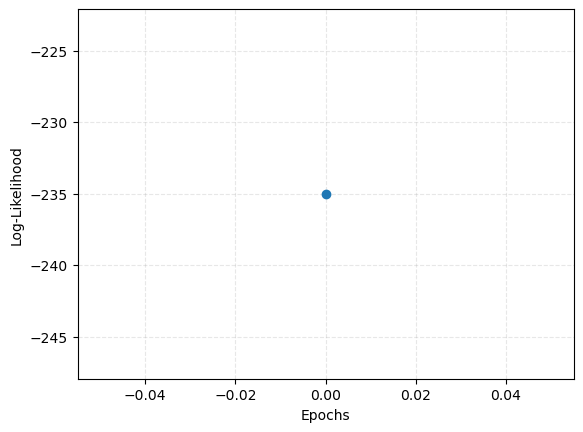

In [10]:
list_e = rbm.log_likelihood.esit_ix
list_l = rbm.log_likelihood.esit

plot_likelihood_evolutions(list_e, [list_l])

## 2.b

In [12]:
rbm = RBM(X_keep, 3, spins=True, potts=False)
list_l = []
for i in range(1,4):
    print(f"CD_steps: {i}")
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", cd_steps=i, verbose=True)
    rbm.likelihood_history(6)
    list_l.append( rbm.log_likelihood.esit )

list_e = rbm.log_likelihood.esit_ix

CD_steps: 1
Training complete.
CD_steps: 2
Training complete.
CD_steps: 3
Training complete.


ValueError: x and y must have same first dimension, but have shapes (6,) and (18,)

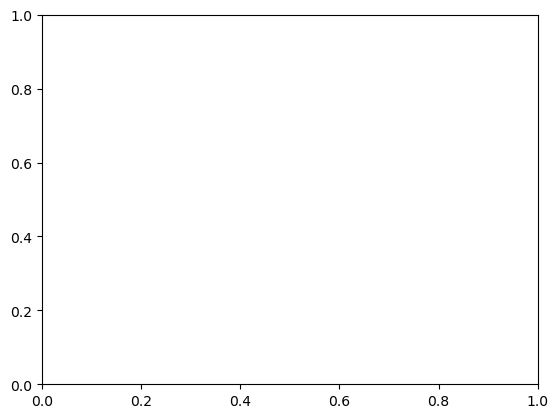

In [13]:
plot_likelihood_evolutions(rbm.log_likelihood.esit_ix, list_l, [f"CD steps: {i+1}" for i in range(len(list_l))])

## 2.c

In [27]:
list_L = list(range(3,11))
list_models = []
list_likelihoods = []
for L in list_L:
    print(f"L: {L}")
    rbm = RBM(X_keep, L, spins=True, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", verbose=True)
    rbm.likelihood_history(1)
    list_models.append(rbm)
    list_likelihoods.append( rbm.log_likelihood.esit[0] )

L: 3
Training complete.
L: 4
Training complete.
L: 5
Training complete.
L: 6
Training complete.
L: 7
Training complete.
L: 8
Training complete.
L: 9
Training complete.
L: 10
Training complete.


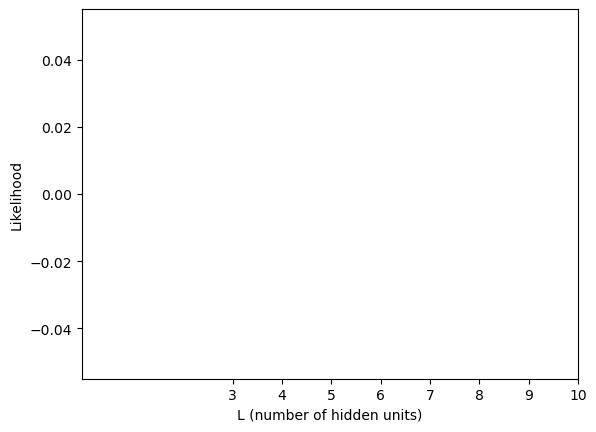

In [28]:
plt.scatter(list_L, list_likelihoods)
# plt.grid(linestyle="--")
plt.xticks(list_L)
plt.xlabel("L (number of hidden units)")
plt.ylabel("Likelihood")
plt.show()

# 3
To change:
- gradient descent
    - type: RMSprop, SGD
    - parameters: leraning rate, epsilon
- spins=True/False
- potts=True/False
- regularization
- ...

## 3.a

ValueError: x and y must have same first dimension, but have shapes (1,) and (18,)

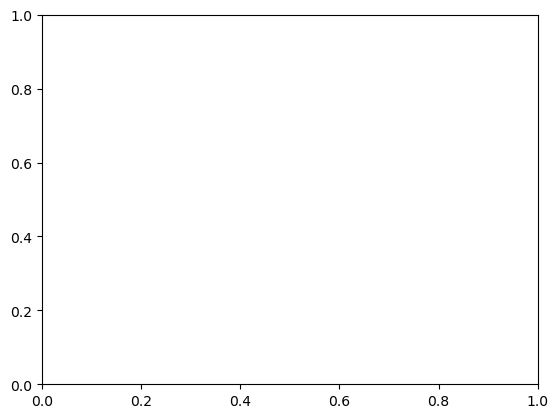

In [30]:
list_e = rbm.log_likelihood.esit_ix
labels = [f"run n°{i+1}" for i in range(len(list_l))]
cmap = cm.RdPu
colors = [cmap(i) for i in np.linspace(0.2,0.8,len(list_l))]
plot_likelihood_evolutions(list_e, list_l, list_labels=labels, colors=colors)

In [ ]:
list_means = []
list_std = []
for likelihoods in list_l:
    last_l = np.array(likelihoods[len(likelihoods)-n_last_likelihoods:])
    list_means.append(last_l.mean())
    list_std.append(last_l.std())

plot_likelihood_means(np.arange(1,len(list_means)+1), list_means, yerr=list_std)

In [ ]:
animate_weights_bias_evolution(rbm.params_history["w"], rbm.params_history["a"], rbm.L)

In [ ]:
list_l_tot = []
for n in range(0,-5,-1):
    rbm = RBM(X_keep, 6, spins=True, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=50, optimizer="RMSprop", lr=10**n, verbose=True)
    rbm.likelihood_history(6)
    
    list_l_tot.append(rbm.log_likelihood.esit)
    
list_e = rbm.log_likelihood.esit_ix

In [ ]:
ns = list(range(0,-5,-1))
plot_likelihood_evolutions(list_e, list_l_tot, list_labels=[f"learning rate = 10^{n}" for n in ns])

In [ ]:
list_l_tot = []
for n in range(-9,-3):
    rbm = RBM(X_keep, 6, spins=True, potts=False)
    rbm.initialize_params()
    rbm.training(epochs=50, optimizer="RMSprop", epsilon=10**n, verbose=True)
    rbm.likelihood_history(6)
    
    list_l_tot.append(rbm.log_likelihood.esit)
    
list_e = rbm.log_likelihood.esit_ix

In [ ]:
ns = list(range(-9,-3))
plot_likelihood_evolutions(list_e, list_l_tot, list_labels=[rf"$\epsilon$ = 10^{n}" for n in ns])

In [ ]:
L = 10
epochs = 150
n_likelihoods = 6

rbm_sgd = RBM(X_keep, L)
rbm_sgd.initialize_params()
rbm_sgd.training(epochs=epochs, optimizer="SGD")
rbm_sgd.likelihood_history(n_likelihoods)

rbm_rms = RBM(X_keep, L)
rbm_rms.initialize_params()
rbm_rms.training(epochs=epochs, optimizer="RMSprop", epsilon=1e-8)
rbm_rms.likelihood_history(n_likelihoods)

In [ ]:
list_e = rbm_sgd.log_likelihood.esit_ix
list_l_sgd = rbm_sgd.log_likelihood.esit
list_l_rms = rbm_rms.log_likelihood.esit

plot_likelihood_evolutions(list_e, [list_l_sgd, list_l_rms], list_labels=["SGD", "RMS"])

In [ ]:
list_l_tot = []
gamma_values = [f"10**{n}" if n != 0 else "0" for n in range(-5,1)]
for gamma in gamma_values:
    rbm = RBM(X_keep, 6)
    rbm.initialize_params()
    rbm.training(epochs=50, optimizer="RMSprop", gamma=eval(gamma), verbose=True)
    rbm.likelihood_history(6)
    
    list_l_tot.append(rbm.log_likelihood.esit)
    
list_e = rbm.log_likelihood.esit_ix

In [ ]:
plot_likelihood_evolutions(list_e, list_l_tot, list_labels=[rf"$\gamma$ = {gamma_values[i].replace('**', '^')}" for i in range(len(list_l_tot))])

In [ ]:
L = 10
epochs = 150
n_likelihoods = 6
lr = 1e-1
epsilon = 1e-8
gamma = 1e-4

# RMSprop
print("Bernoulli")
rbm_bern = RBM(X_keep, L)
rbm_bern.initialize_params()
rbm_bern.training(epochs=epochs, optimizer="RMSprop", epsilon=epsilon, gamma=gamma, verbose=True)
rbm_bern.likelihood_history(n_likelihoods)

'''print("Spins")
rbm_spin = RBM(X_keep, L, spins=True)
rbm_spin.initialize_params()
rbm_spin.training(epochs=epochs, optimizer="RMSprop", epsilon=epsilon, gamma=gamma, verbose=True)
rbm_spin.likelihood_history(n_likelihoods)'''

print("POTTS")
rbm_potts = RBM(X_keep, L, potts=True)
rbm_potts.initialize_params()
rbm_potts.training(epochs=epochs, optimizer="RMSprop", epsilon=epsilon, gamma=gamma, verbose=True)
rbm_potts.likelihood_history(n_likelihoods)

In [ ]:
plot_likelihood_evolutions(list_e, [list_l_bern, list_l_spin, list_l_potts], list_labels=["Bernoulli", "Spins", "POTTS"])

In [ ]:
L = 10
epochs = 150
n_likelihoods = 6
gamma = 1e-4

# SGD
print("Bernoulli")
rbm_bern = RBM(X_keep, L)
rbm_bern.initialize_params()
rbm_bern.training(epochs=epochs, optimizer="SGD", gamma=gamma, verbose=True)
rbm_bern.likelihood_history(n_likelihoods)

'''print("Spins")
rbm_spin = RBM(X_keep, L, spins=True)
rbm_spin.initialize_params()
rbm_spin.training(epochs=epochs, optimizer="SGD", gamma=gamma, verbose=True)
rbm_spin.likelihood_history(n_likelihoods)'''

print("POTTS")
rbm_potts = RBM(X_keep, L, potts=True)
rbm_potts.initialize_params()
rbm_potts.training(epochs=epochs, optimizer="SGD", gamma=gamma, verbose=True)
rbm_potts.likelihood_history(n_likelihoods)

In [ ]:
plot_likelihood_evolutions(list_e, [list_l_bern, list_l_spin, list_l_potts], list_labels=["Bernoulli", "Spins", "POTTS"])

In [11]:
rbm = RBM(X_keep, 5, spins=True)
rbm.initialize_params()
rbm.training(epochs=30, optimizer="SGD", verbose=True)

Training complete.


In [12]:
rbm.likelihood_history(10)

In [15]:
rbm.log_likelihood.esit

[-158132.79165606876,
 -166079.12684087947,
 -165306.70989332936,
 -163659.93809561603,
 -161745.99967240874,
 -163601.1470705601,
 -163184.78554939033,
 -162487.54403784327,
 -162225.6208944724,
 -162832.41351134304]

Let's check if something changes when a simulation is run with the same hyperparameters different times.

In [ ]:
list_l = []
N = 5
n_last_likelihoods = 6
steps=6
for n in range(N):
    print(f"n run: {n}")
    rbm = RBM(X_keep, 10)
    rbm.initialize_params()
    rbm.training(epochs=150, optimizer="RMSprop", epsilon=1e-8, gamma=1e-4, verbose=True)
    rbm.likelihood_history(12,n_last_likelihoods, steps)
    list_l.append(rbm.log_likelihood.esit)

In [ ]:
cmap = "Reds"
ix = np.random.choice(len(X_keep))
x_test = binarize_data(X_keep[ix])
v, _ = rbm.test(x_test)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(binarize_data(X_keep[ix], 0, 1).reshape((28,28)), cmap=cmap)
axes[1].imshow(v[-1].reshape((28,28)), cmap=cmap)
plt.show()

## Bernoulli

In [ ]:
rbm = RBM(X_keep, 3, spins=True, potts=False)
rbm.initialize_params()
rbm.training(epochs=20, optimizer="SGD")

In [ ]:
rbm.likelihood_history(5)
print(rbm.log_likelihood.esit)

In [ ]:
cmap = "Reds"
ix = np.random.choice(len(X_keep))
x_test = binarize_data(X_keep[ix], -1)
v, _ = rbm.test(x_test)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(X_keep[ix].reshape((28,28)), cmap=cmap)
axes[1].imshow(v[-1].reshape((28,28)), cmap=cmap)
plt.show()

## POTTS = True

In [ ]:
rbm = RBM(X_keep, 12, spins=True, potts=True)
rbm.initialize_params()
rbm.training(epochs=120, optimizer="RMSprop", verbose=True)

In [ ]:
cmap = "Reds"
ix = np.random.choice(len(X_keep))
x_test = binarize_data(X_keep[ix])
v, _ = rbm.test(x_test)

fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(X_keep[ix].reshape((28,28)), cmap=cmap)
axes[1].imshow(v[-1].reshape((28,28)), cmap=cmap)
plt.show()